# P4 - Anticipez les besoins en consommation électrique de bâtiments

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

- Problématique de la ville de Seattle

Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.

Votre mission:
Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

- Réaliser une courte analyse exploratoire.
- Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes, et erreurs à éviter :
- L’objectif est de te passer des relevés de consommation annuels (attention à la fuite de données), mais rien ne t'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

- Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

- Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.

# Partie 1 - Nettoyage et analyse exploratoire

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set()
plt.style.use('seaborn-whitegrid')


Les csvs et les jsons sont à télécharger après création d'un compte Kaggle à cette adresse : https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv

In [2]:
data_2015 = pd.read_csv("2015-building-energy-benchmarking.csv")
data_2016 = pd.read_csv("2016-building-energy-benchmarking.csv")

## Observation des données

In [3]:
print("Taille dataset 2015 : ", data_2015.shape)
print("Taille dataset 2016 : ", data_2016.shape)

Taille dataset 2015 :  (3340, 47)
Taille dataset 2016 :  (3376, 46)


In [4]:
# On peut constater qu'il y aura des valeurs aberrantes à traiter (ex: valeurs négatives de surface, consommation négative)
# et des valeurs potentiellement manquantes (ex: consommation ou émission nulle) 
data_2015.describe()
# data_2016.describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,...,NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
count,3340.000000,3340.0,3340.000000,3340.000000,3340.000000,3332.000000,3.340000e+03,3340.000000,3.340000e+03,3.204000e+03,...,3.330000e+03,3.330000e+03,3.330000e+03,3330.000000,3330.000000,224.000000,3338.000000,213.000000,3338.000000,3340.000000
mean,20522.168263,2015.0,4.450898,1967.624850,1.035629,4.682173,9.077289e+04,11054.032335,7.971886e+04,7.488154e+04,...,1.253304e+04,1.253304e+06,7.142301e+03,110.094102,0.985339,123.062500,32.380168,1.347418,24.825644,18786.680240
std,11511.515874,0.0,2.127203,32.949847,0.784463,5.458460,1.493058e+05,35296.330507,1.292314e+05,1.236249e+05,...,4.415142e+04,4.415142e+06,1.962790e+05,409.450179,1.637172,5.812128,19.907567,0.477272,15.006287,588.604192
min,1.000000,2015.0,1.000000,1900.000000,1.000000,0.000000,2.000000e+04,-3.000000,-5.055000e+04,5.872000e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,116.000000,1.000000,1.000000,1.000000,17916.000000
25%,19921.750000,2015.0,3.000000,1947.000000,1.000000,2.000000,2.848700e+04,0.000000,2.668300e+04,2.500000e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,9.265000,0.080000,117.000000,14.000000,1.000000,10.000000,18379.000000
50%,22977.000000,2015.0,4.000000,1973.000000,1.000000,4.000000,4.385500e+04,0.000000,4.132600e+04,3.900000e+04,...,2.945500e+03,2.945770e+05,0.000000e+00,32.740000,0.460000,123.000000,33.000000,1.000000,26.000000,18390.000000
75%,25748.000000,2015.0,7.000000,1996.000000,1.000000,5.000000,8.842800e+04,4304.250000,7.872600e+04,7.206750e+04,...,1.115325e+04,1.115366e+06,0.000000e+00,88.642500,1.180000,125.500000,50.000000,2.000000,38.000000,19576.000000
max,50059.000000,2015.0,7.000000,2015.000000,39.000000,99.000000,2.200000e+06,512608.000000,2.200000e+06,1.719643e+06,...,1.364484e+06,1.364484e+08,8.269669e+06,11824.890000,31.380000,135.000000,61.000000,2.000000,51.000000,19584.000000


In [5]:
# on constate des différences dans les noms des colonnes des deux datasets

print('Colonnes communes aux deux datasets :\n')
print([col for col in data_2015.columns if col in data_2016.columns])

print('\nColonnes uniques au dataset 2015 :\n')
print([col for col in data_2015.columns if col not in data_2016.columns])

print('\nColonnes uniques au dataset 2016 : \n')
print([col for col in data_2016.columns if col not in data_2015.columns])

Colonnes communes aux deux datasets :

['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier']

Colonnes uniques au dataset 2015 :

['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)

In [6]:
import json

def print_col_desc(file_2015, file_2016):
    '''
    Ouvre les fichiers json et imprime la description de chaque colonne
    '''
    with open(file_2015) as f_15:
        data_desc_15 = json.load(f_15)
    with open(file_2016) as f_16:
        data_desc_16 = json.load(f_16)
    for col_15, col_16 in zip(data_desc_15['columns'], data_desc_16['columns']):
        try:
            print('-', col_15['name'], ':', col_15['description'])
        except:
            try:
                print('-', col_16['name'], ':', col_16['description'])
            except:
                print('-', col_15['name'])    
        
print_col_desc('socrata_metadata_2015-building-energy-benchmarking.json',
               'socrata_metadata_2016-building-energy-benchmarking.json')

- OSEBuildingID : A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.
- DataYear : Calendar year (January-December) represented by each data record.
- BuildingType : City of Seattle building type classification.
- PrimaryPropertyType : The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager.
- PropertyName : Official or common property name.
- TaxParcelIdentificationNumber : 	
Property King County PIN
- City : Property city
- CouncilDistrictCode : Property City of Seattle council district.
- ZipCode : Property zip
- YearBuilt : Year in which a property was constructed or underwent a complete renovation.
- CouncilDistrictCode : Property City of Seattle council district.
- Neighborhood : Property neighborhood area defined by the City of Seattle Depart

In [7]:
def build_nan_barplot(df_list, df_names, figsize=(20,7), color_xticklabels=False, labels_to_color=[]):
    '''
    Fonction pour tracer un ou plusieurs barplots qui représente(nt) la proportion 
    de valeurs nulles par colonnes dans le(s) dataframe(s)
    '''
    fig = plt.figure(figsize=figsize)

    for df, name in zip(df_list, df_names):
        fig.add_subplot(1, len(df_list), df_names.index(name) + 1)
        nb_nan = df.isna().sum() * 100 / len(df)
        ax = nb_nan.plot(kind='bar')
        ax.set_ylabel('Null values (%)')
#         plt.text(s=name, x=0, y=100, color='red')
        plt.title('Valeurs manquantes dans la table ' + name, fontsize=20)
        
        if color_xticklabels:
            for xtick in ax.get_xticklabels():
                if xtick.get_text() in labels_to_color[df_names.index(name)]:
                    xtick.set_color('red')
                    
    x = nb_nan.index
    y = nb_nan.values
    
    for i in range(len(x)):
        if y[i] > 1:
            plt.text(i, y[i], round(y[i],1), ha = 'center', fontsize=12)
        elif y[i] > 0:
            plt.text(i, y[i], round(y[i],2), ha = 'center', fontsize=12)
            

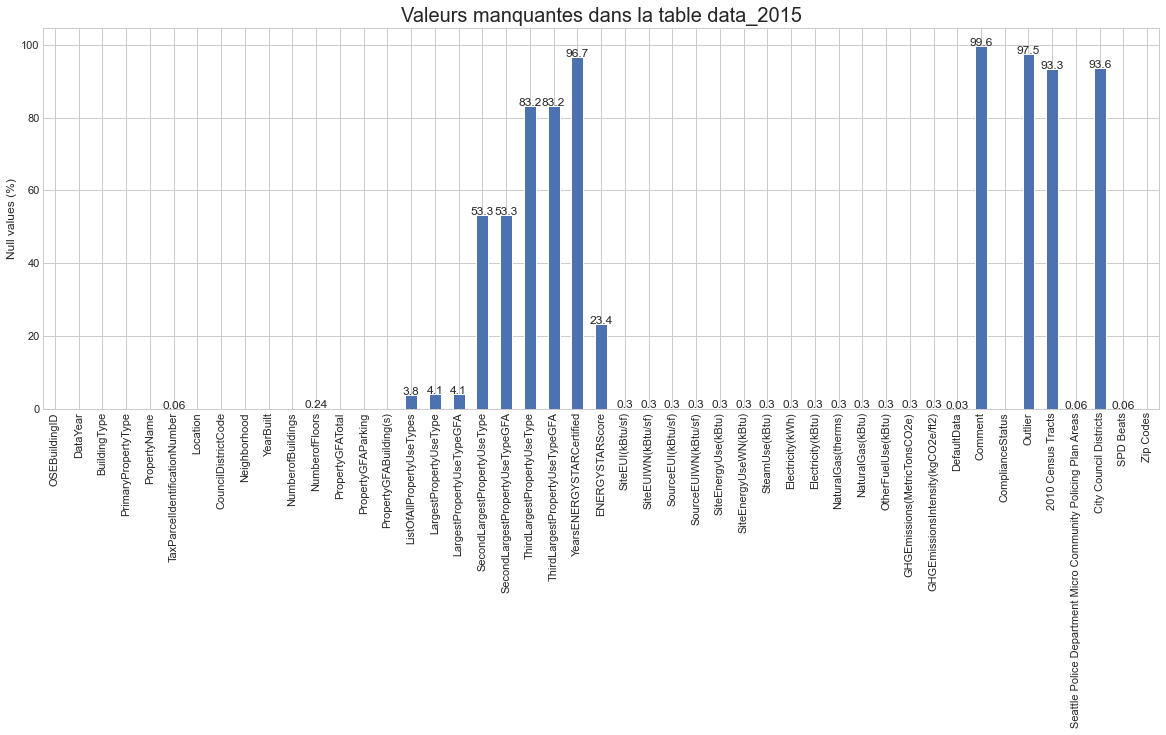

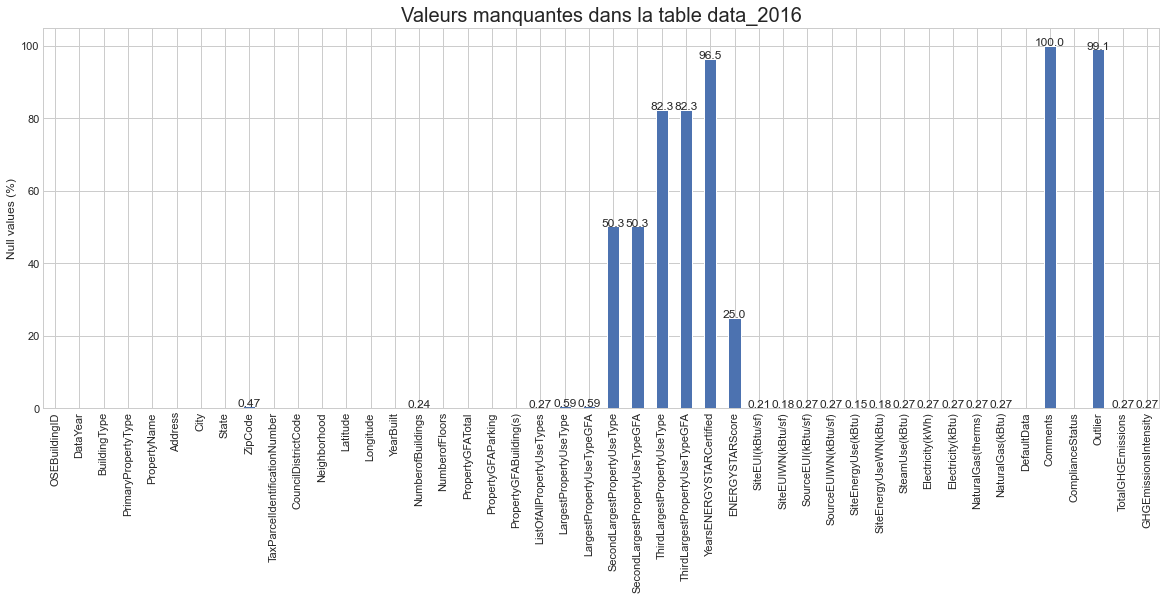

In [8]:
build_nan_barplot([data_2015], ['data_2015'])
build_nan_barplot([data_2016], ['data_2016'])

## Nettoyage des données

### Uniformisation des datasets

On uniformise les données des datasets de 2015 et 2016 :
- valeurs des variables catégorielles dans les colonnes 'Neighborhood', 'Outlier', 'PrimaryPropertyType'
- types des colonnes et remplacement des valeurs nulles dans 'NumberofBuildings' et 'NumberofFloors'
- ajout des colonnes 'Address', 'Latitude', 'Longitude', 'ZipCode' pour 2015
- ajout de la colonne 'OtherFuelUse(kBtu)' pour 2016
- uniformisation des noms des colonnes d'émissions de gaz et de commentaires

On remplace les valeurs aberrantes :
- dans les données de 2015 on a des valeurs négatives pour la surface du parking ou du bâtiment


In [9]:
print('Neighborhood 2015:\n', set(data_2015.Neighborhood.tolist()), '\n')
print('Neighborhood 2016:\n', set(data_2016.Neighborhood.tolist()), '\n')

# uniformiser les quartiers 2016 : passer les noms en majuscules et 'DELRIDGE NEIGHBORHOODS' = 'DELRIDGE'

data_2016['Neighborhood'] = data_2016['Neighborhood'].str.upper().replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')

print('Neighborhood 2016 après uniformisation:\n', set(data_2016.Neighborhood.tolist()))

Neighborhood 2015:
 {'NORTH', 'MAGNOLIA / QUEEN ANNE', 'DOWNTOWN', 'CENTRAL', 'SOUTHWEST', 'LAKE UNION', 'GREATER DUWAMISH', 'NORTHWEST', 'SOUTHEAST', 'EAST', 'BALLARD', 'DELRIDGE', 'NORTHEAST'} 

Neighborhood 2016:
 {'MAGNOLIA / QUEEN ANNE', 'DOWNTOWN', 'Central', 'CENTRAL', 'BALLARD', 'NORTHEAST', 'DELRIDGE NEIGHBORHOODS', 'SOUTHWEST', 'North', 'Ballard', 'EAST', 'Northwest', 'LAKE UNION', 'GREATER DUWAMISH', 'NORTHWEST', 'SOUTHEAST', 'DELRIDGE', 'NORTH', 'Delridge'} 

Neighborhood 2016 après uniformisation:
 {'NORTH', 'MAGNOLIA / QUEEN ANNE', 'DOWNTOWN', 'CENTRAL', 'SOUTHWEST', 'LAKE UNION', 'GREATER DUWAMISH', 'NORTHWEST', 'SOUTHEAST', 'EAST', 'BALLARD', 'DELRIDGE', 'NORTHEAST'}


In [10]:
print('Outlier 2015:\n', set(data_2015.Outlier.tolist()), '\n')
print('Outlier 2016:\n', set(data_2016.Outlier.tolist()), '\n')

# uniformiser la colonne Outlier 2016 : le mot "outlier" a une majuscule dans le dataset 2015

data_2016['Outlier'] = data_2016['Outlier'].str.title()

print('Outlier 2016 après uniformisation:\n', set(data_2016.Outlier.tolist()))

Outlier 2015:
 {nan, 'High Outlier', 'Low Outlier'} 

Outlier 2016:
 {nan, 'Low outlier', 'High outlier'} 

Outlier 2016 après uniformisation:
 {nan, 'High Outlier', 'Low Outlier'}


In [11]:
print('NumberofBuildings 2015:\n', data_2015.NumberofBuildings.dtypes, '\n', set(data_2015.NumberofBuildings.tolist()), '\n')
print('NumberofBuildings 2016:\n', data_2016.NumberofBuildings.dtypes, '\n', set(data_2016.NumberofBuildings.tolist()), '\n')

# uniformiser les données 2016 : passer le champ en int et remplacer les nan et les 0

nan_buildings = data_2016[(data_2016['NumberofBuildings'].isna()) | (data_2016['NumberofBuildings'] == 0)].OSEBuildingID.tolist()

# Les valeurs de 2015 sont de 1 pour les données de 2016 avec NaN ou 0
# on les remplace donc par 1

print(set(data_2015[data_2015['OSEBuildingID'].isin(nan_buildings)].NumberofBuildings.tolist()))

data_2016['NumberofBuildings'] = data_2016['NumberofBuildings'].fillna(1).astype('int64')
data_2016['NumberofBuildings'] = np.where(data_2016['NumberofBuildings'] == 0, 1, data_2016['NumberofBuildings'])

print('NumberofBuildings 2016 après uniformisation:\n', data_2016.NumberofBuildings.dtypes, '\n', set(data_2016.NumberofBuildings.tolist()), '\n')


NumberofBuildings 2015:
 int64 
 {1, 2, 3, 4, 6, 7, 39, 10, 11, 16} 

NumberofBuildings 2016:
 float64 
 {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan, 7.0, 9.0, nan, 11.0, 8.0, nan, 14.0, nan, 16.0, 10.0, 23.0, 27.0, nan, nan, nan, nan, 111.0} 

{1}
NumberofBuildings 2016 après uniformisation:
 int64 
 {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 111, 16, 23, 27} 



In [12]:
print('NumberofFloors 2015:\n', data_2015.NumberofFloors.dtypes, '\n', set(data_2015.NumberofFloors.tolist()), '\n')
print('NumberofFloors 2016:\n', data_2016.NumberofFloors.dtypes, '\n', set(data_2016.NumberofFloors.tolist()), '\n')

# uniformiser les données 2015 : passer le champ en int et remplacer les nan par 0
# On a 8 valeurs à NaN en 2015 qu'on choisit de remplacer par 0,
# mais les entrées sont présentes en 2016 et ce sont celles que l'on utilisera par la suite

data_2015['NumberofFloors'] = data_2015['NumberofFloors'].fillna(0).astype('int64')

print('NumberofFloors 2015 après uniformisation:\n', data_2015.NumberofFloors.dtypes, '\n', set(data_2015.NumberofFloors.tolist()), '\n')

NumberofFloors 2015:
 float64 
 {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, nan, 33.0, 34.0, nan, 36.0, 37.0, 38.0, 39.0, nan, 41.0, 42.0, 32.0, 40.0, 46.0, 47.0, 49.0, 55.0, 56.0, 63.0, nan, nan, nan, nan, nan, 76.0, 99.0} 

NumberofFloors 2016:
 int64 
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 46, 47, 49, 55, 56, 63, 76, 99} 

NumberofFloors 2015 après uniformisation:
 int64 
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 46, 47, 49, 55, 56, 63, 76, 99} 



In [13]:
#  Attention valeurs aberrantes négatives pour les surfaces en 2015
#  On remplace les surfaces de Parking par 0, et les surfaces de bâtiments par les surfaces totales,
#  ce qui semble cohérent par rapport à 2016

buildings_abberr = data_2015[(~data_2015['PropertyGFAParking'] >= 0) | (~data_2015['PropertyGFABuilding(s)'] > 0)]
print(buildings_abberr[['PropertyGFAParking', 'PropertyGFABuilding(s)', 'PropertyGFATotal']])
print('\n', data_2016[data_2016['OSEBuildingID'].isin(buildings_abberr.OSEBuildingID.tolist())]
        [['PropertyGFAParking', 'PropertyGFABuilding(s)', 'PropertyGFATotal']])

data_2015['PropertyGFAParking'] = np.where(data_2015['OSEBuildingID'].isin(buildings_abberr.OSEBuildingID.tolist()),
                                           0, data_2015['PropertyGFAParking'])
    
data_2015['PropertyGFABuilding(s)'] = np.where(data_2015['OSEBuildingID'].isin(buildings_abberr.OSEBuildingID.tolist()),
                                           data_2015['PropertyGFATotal'], data_2015['PropertyGFABuilding(s)'])

      PropertyGFAParking  PropertyGFABuilding(s)  PropertyGFATotal
2428                  -3                   20970             20967
3136                  -2                   68454             68452
3139               97325                  -43310             54015
3322               84198                  -50550             33648

       PropertyGFAParking  PropertyGFABuilding(s)  PropertyGFATotal
2400                   0                   20967             20967
3095                   0                   68452             68452
3098                   0                   54015             54015
3294                   0                   33648             33648


In [14]:
# On a les colonnes Address, latitude, longitude, ZipCode pour 2016, on peut déduire les mêmes colonnes de 'Location' pour 2015
import ast

def parse_location(loc, value_name):
    '''
    Fonction qui récupère les informations présentes dans la colonne 'Location'
    pour en extraire de nouvelles colonnes
    '''
    if value_name in ['address', 'zip']:
        try:
            return ast.literal_eval(ast.literal_eval(loc)['human_address'])[value_name]
        except:
            return ''
    try:
        return ast.literal_eval(loc)[value_name]
    except:
        return 0

data_2015['Latitude'] = data_2015.apply(lambda x : parse_location(x['Location'], 'latitude'), axis=1).astype(float)
data_2015['Longitude'] = data_2015.apply(lambda x : parse_location(x['Location'], 'longitude'), axis=1).astype(float)
data_2015['Address'] = data_2015.apply(lambda x : parse_location(x['Location'], 'address'), axis=1)
data_2015['ZipCode'] = data_2015.apply(lambda x : parse_location(x['Location'], 'zip'), axis=1).astype(float)

In [15]:
# On uniformise les noms des colonnes 2015 et 2016

data_2016.rename(columns={'TotalGHGEmissions': 'GHGEmissions(MetricTonsCO2e)',
                          'GHGEmissionsIntensity': 'GHGEmissionsIntensity(kgCO2e/ft2)',
                          'Comments':'Comment'}, inplace=True)

In [16]:
#  On calcule 'OtherFuelUse(kBtu)' pour 2016 
# ('SteamUse(kBtu)'+'Electricity(kBtu)'+'NaturalGas(kBtu)'+'OtherFuelUse(kBtu)' = 'SiteEnergyUse(kBtu)')

data_2016['OtherFuelUse(kBtu)'] = data_2016['SiteEnergyUse(kBtu)'] - data_2016[['SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)']].sum(axis=1)

In [17]:
types_2015 = set(data_2015.PrimaryPropertyType.tolist())
types_2016 = set(data_2016.PrimaryPropertyType.tolist())

print(types_2015, '\n')
print(types_2016)

{'Medical Office', 'Restaurant\n', 'Hotel', 'Distribution Center', 'Senior Care Community', 'Laboratory', 'SPS-District K-12', 'Hospital', 'Large Office', 'Low-Rise Multifamily', 'Distribution Center\n', 'Non-Refrigerated Warehouse', 'High-Rise Multifamily', 'Refrigerated Warehouse', 'Self-Storage Facility', 'Mid-Rise Multifamily', 'College/University', 'Mixed Use Property', 'Worship Facility', 'K-12 School', 'Self-Storage Facility\n', 'Small- and Mid-Sized Office', 'Supermarket/Grocery Store', 'Residence Hall/Dormitory', 'Other', 'Restaurant', 'Retail Store'} 

{'Medical Office', 'Warehouse', 'Hotel', 'Distribution Center', 'Supermarket / Grocery Store', 'Residence Hall', 'Senior Care Community', 'University', 'Laboratory', 'Hospital', 'Large Office', 'Office', 'Low-Rise Multifamily', 'High-Rise Multifamily', 'Refrigerated Warehouse', 'Self-Storage Facility', 'Mid-Rise Multifamily', 'Mixed Use Property', 'Worship Facility', 'K-12 School', 'Small- and Mid-Sized Office', 'Other', 'Resta

In [18]:
print('PrimaryPropertyType 2015 non présents en 2016:\n', [x for x in types_2015 if x not in types_2016], '\n')
print('PrimaryPropertyType 2016 non présents en 2015:\n', [x for x in types_2016 if x not in types_2015])

# reformater les champs qui contiennent '\n' pour 2015
# uniformiser les champs 2015-2016 'Supermarket/Grocery Store', 'Residence Hall/Dormitory', 'College/University'
# 'SPS-District K-12' (2015) devient 'K-12 School' en 2016

data_2015['PrimaryPropertyType'] = data_2015.PrimaryPropertyType.apply(lambda x: x.replace('\n', '').replace(
                                                                        'Non-Refrigerated ', '').replace(
                                                                        'SPS-District K-12', 'K-12 School'))
data_2016['PrimaryPropertyType'] = data_2016.PrimaryPropertyType.apply(lambda x: x.replace(' / ', '/').replace(
                                                                        'Residence Hall','Residence Hall/Dormitory').replace(
                                                                        'University', 'College/University'))

types_2015 = set(data_2015.PrimaryPropertyType.tolist())
types_2016 = set(data_2016.PrimaryPropertyType.tolist())
print('\nPrimaryPropertyType 2015 après uniformisation non présents en 2016:\n',
      [x for x in types_2015 if x not in types_2016], '\n')
print('PrimaryPropertyType 2016 après uniformisation non présents en 2015:\n',
      [x for x in types_2016 if x not in types_2015])

PrimaryPropertyType 2015 non présents en 2016:
 ['Restaurant\n', 'SPS-District K-12', 'Distribution Center\n', 'Non-Refrigerated Warehouse', 'College/University', 'Self-Storage Facility\n', 'Supermarket/Grocery Store', 'Residence Hall/Dormitory'] 

PrimaryPropertyType 2016 non présents en 2015:
 ['Warehouse', 'Supermarket / Grocery Store', 'Residence Hall', 'University', 'Office']

PrimaryPropertyType 2015 après uniformisation non présents en 2016:
 [] 

PrimaryPropertyType 2016 après uniformisation non présents en 2015:
 ['Office']


### Concaténation des données

On garde les colonnes qui semblent utiles pour répondre à la problématique (potentielles variables et données à prédire), et celles qui vont nous servir à éviter les doublons en faisant la concaténation des datasets ('OSEBuildingID') ou à repérer des valeurs aberrantes.

On supprime ou on remplace les valeurs aberrantes, incohérentes :
- valeurs qui ont une très grosse différence entre 2015-2016 et ressemblent à des erreurs de remplissage
- on remplace aussi les années de construction lorsqu'il y a eu de gros travaux

In [19]:
col_to_keep = ['OSEBuildingID', 'BuildingType', 'Comment', 'PropertyName', 'PrimaryPropertyType', 'CouncilDistrictCode',
               'Neighborhood', 'YearBuilt', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
               'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes','LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
               'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
               'ThirdLargestPropertyUseTypeGFA', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
               'NaturalGas(kBtu)', 'Outlier', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',  'ENERGYSTARScore',
               'SourceEUIWN(kBtu/sf)', 'Latitude', 'Longitude']

data_2015 = data_2015[col_to_keep]
data_2016 = data_2016[col_to_keep]
data_2015 = data_2015.add_suffix('_2015')
data_2016 = data_2016.add_suffix('_2016')

In [20]:
data = data_2015.merge(data_2016, left_on='OSEBuildingID_2015', right_on='OSEBuildingID_2016', how='outer')

In [21]:
# on regarde les entrées qui ont changé entre 2015 et 2016

for col in col_to_keep:
    col1 = col + '_2015'
    col2 = col + '_2016'
    print(data[(~data[col1].isna()) & (~data[col2].isna()) & (data[col1] != data[col2])][[col1, col2]], '\n')

Empty DataFrame
Columns: [OSEBuildingID_2015, OSEBuildingID_2016]
Index: [] 

         BuildingType_2015     BuildingType_2016
979   Multifamily LR (1-4)        NonResidential
1711    Nonresidential COS                Campus
1727  Multifamily MR (5-9)  Multifamily LR (1-4) 

Empty DataFrame
Columns: [Comment_2015, Comment_2016]
Index: [] 

                   PropertyName_2015                     PropertyName_2016
0               MAYFLOWER PARK HOTEL                  Mayflower park hotel
1                    PARAMOUNT HOTEL                       Paramount Hotel
2                       WESTIN HOTEL               5673-The Westin Seattle
4              WARWICK SEATTLE HOTEL           WARWICK SEATTLE HOTEL (ID8)
5     WEST PRECINCT (SEATTLE POLICE)                         West Precinct
...                              ...                                   ...
3335      PACIFIC CENTER CONDOMINIUM  PACIFIC CENTER CONDOMINIUM (ID50049)
3336              IDENTITY APTS 4123  129610 - Identity Se

3186                               3611.0                          3610.000000 

      SiteEnergyUse(kBtu)_2015  SiteEnergyUse(kBtu)_2016
0                    6981428.0              7.226362e+06
1                    8354235.0              8.387933e+06
2                   73130656.0              7.258702e+07
3                   28229320.0              6.794584e+06
4                   14829099.0              1.417261e+07
...                        ...                       ...
3335                 1142949.0              1.248599e+06
3336                 1543282.0              1.625696e+06
3337                16834414.0              1.540416e+07
3338                  777064.0              7.833457e+05
3339                  966376.0              9.668121e+05

[3272 rows x 2 columns] 

      SteamUse(kBtu)_2015  SteamUse(kBtu)_2016
0               2023032.0         2.003882e+06
2              19660404.0         2.156655e+07
3              23458518.0         2.214446e+06
7               2003

In [22]:
# on remarque une incohérence dans le nombre de bâtiments pour l'université de Seattle,
# qui avait 39 bâtiments en 2015 et seulement 1 en 2016, on choisit de prendre la valeur de 2015

index_univ = data[data['OSEBuildingID_2015'] == 22062].index[0]
data.at[index_univ, 'NumberofBuildings_2016'] = 39

In [23]:
# En comparant les dépenses d'énergie 2015-2016 on remarque des incohérences possibles
# ex: OSEBuildingID = 5 avec SteamUse(kBtu)_2015 = 2.34585e+07 et SteamUse(kBtu)_2016 = 2.21445e+06

# 13-18 bâtiments ont une grande différence entre 2015-2016 (multiplicateur de 3 à 10)
# les superficies et property_type n'ont pas changées, certaines différences ressemblent à des erreurs de remplissage, 
# telles qu'une erreur de position de virgule
# On retire ces bâtiments de l'étude pour limiter l'erreur humaine

to_remove = data[(data['SiteEnergyUse(kBtu)_2015']>0) & (data['SiteEnergyUse(kBtu)_2016']>0) & (
    (data['SiteEnergyUse(kBtu)_2015']>data['SiteEnergyUse(kBtu)_2016']*3) | (
    data['SiteEnergyUse(kBtu)_2016']>data['SiteEnergyUse(kBtu)_2015']*3))].index

data = data[~data.index.isin(to_remove)]

In [24]:
# Il faut modifier certaines années de construction car les bâtiments ont été entièrement reconstruits
import re

def get_new_built_year(df):
    '''
    Extract from the field 'Comment_2015' the new construction year
    and replace it in the fields 'YearBuilt_2015' and 'YearBuilt_2016'
    '''
    regexp = r'(.*)Year built changed from ([\d]*) to ([\d]*)'
       
    for i, row in df.iterrows():
        try:
            result = re.search(regexp, row['Comment_2015'])
            df.loc[i,'YearBuilt_2015'] = float(result.group(3))
            df.loc[i,'YearBuilt_2016'] = float(result.group(3))
        except:
            pass
    
    return df

data = get_new_built_year(data)
data[~data['Comment_2015'].isna()][['Comment_2015', 'YearBuilt_2015', 'YearBuilt_2016']]

,Comment_2015,YearBuilt_2015,YearBuilt_2016
62,Under construction starting 6/2013 (old buildi...,2016.0,2016.0
436,"Part of McKinstry's campus, property operates ...",1973.0,1973.0
437,One of two office buildings on McKinstry's cam...,1948.0,1948.0
595,"Part of McKinstry’s campus, this remodeled war...",1950.0,1950.0
719,Construction completed in mid 2015. The buildi...,1925.0,1925.0
1358,Under construction starting 6/2013 (old buildi...,2016.0,2016.0
1360,Under construction starting 6/2013 (old buildi...,2016.0,2016.0
1373,Under construction starting 6/2015 (old buildi...,2017.0,2017.0
2108,Under construction starting 09/2014 (old build...,2017.0,2017.0
2230,"Part of McKinstry's campus, the office space f...",2009.0,2009.0


In [25]:
# On garde les données 2016 si on les a sinon 2015

# Attention : parfois on a SiteEnergyUse(kBtu) mais pas les précisions par source d'énergie pour 2016 donc prendre 2015
# (si SiteEnergyUse(kBtu)_2016 = OtherFuelUse(kBtu)_2016 on prend 2015)

# Si on a l'ESS pour 2015 et pas 2016 on garde 2015

data['data_to_keep'] = np.where((data['SiteEnergyUse(kBtu)_2016'] > 0) & (
                                data['SiteEnergyUse(kBtu)_2016'] > data['OtherFuelUse(kBtu)_2016']) & (
                                (~data['ENERGYSTARScore_2016'].isna()) | (data['ENERGYSTARScore_2015'].isna())),
                                2016, 2015)

for col in col_to_keep:
    col1 = col + '_2015'
    col2 = col + '_2016'
    data[col] = np.where((data['data_to_keep'] == 2015) & (~data[col1].isna()) | (data[col2].isna()) , data[col1], data[col2])
    
data = data[col_to_keep]

In [26]:
# On a 5 rows avec une consommation d'énergie ou une émission de CO2 nulle, on les supprime
print(data.shape)
data = data[(data['GHGEmissions(MetricTonsCO2e)'] > 0) & (data['SiteEnergyUse(kBtu)'] > 0)]
print(data.shape)

(3414, 31)
(3409, 31)


## Choix et transformation des variables

On regarde la liste des types d'usage et leur fréquence pour voir si certains peuvent être regroupés


Deux buts : réduire le nombre de variables totales et réduire le nombre de variables sous représentées


In [27]:
list_types = set([x for x in data['LargestPropertyUseType'].tolist() 
                + data['SecondLargestPropertyUseType'].tolist() 
                + data['ThirdLargestPropertyUseType'].tolist() if x == x])

low_ratio = []
high_ratio = []

for types in list_types:
    ratio = ((data['LargestPropertyUseType']==types).sum() + (data['SecondLargestPropertyUseType']==types).sum()
          + (data['ThirdLargestPropertyUseType']==types).sum())* 100 / len(data)
    if ratio < 1 :
        low_ratio.append((types, ratio))
    else:
        high_ratio.append((types, ratio))

for r in low_ratio:
    print(r)


('Convenience Store without Gas Station', 0.08800234672924612)
('Lifestyle Center', 0.05866823115283074)
('Food Service', 0.46934584922264594)
('Vocational School', 0.05866823115283074)
('Automobile Dealership', 0.23467292461132297)
('Other - Lodging/Residential', 0.32267527134056906)
('Other/Specialty Hospital', 0.17600469345849223)
('Bar/Nightclub', 0.17600469345849223)
('Urgent Care/Clinic/Other Outpatient', 0.11733646230566148)
('Other - Mall', 0.11733646230566148)
('Residential Care Facility', 0.02933411557641537)
('Fitness Center/Health Club/Gym', 0.8213552361396304)
('Other - Education', 0.23467292461132297)
('Movie Theater', 0.11733646230566148)
('Wholesale Club/Supercenter', 0.02933411557641537)
('Police Station', 0.02933411557641537)
('Laboratory', 0.6453505426811381)
('Bank Branch', 0.4986799647990613)
('Pre-school/Daycare', 0.32267527134056906)
('Other - Services', 0.557348195951892)
('Other - Public Services', 0.17600469345849223)
('Fire Station', 0.02933411557641537)
('Ou

In [28]:
# on teste en regroupant des catégories car beaucoup ont une très faible représentation dans le dataset (< 1%)
# on se base sur la description des catégories qui est faite à cette adresse :
# https://www.energystar.gov/buildings/benchmark/understand_metrics/property_types

college = ['Adult Education', 'Other - Education', 'College/University', 'Vocational School']
mall = ['Other - Mall','Strip Mall', 'Enclosed Mall']
restaurant = ['Restaurant', 'Fast Food Restaurant','Other - Restaurant/Bar']
housing = ['Other - Lodging/Residential', 'Residence Hall/Dormitory', 'Multifamily Housing']
care = ['Residential Care Facility', 'Senior Care Community']
entertainment = ['Other - Entertainment/Public Assembly','Performing Arts','Movie Theater', 'Museum']
recreation = ['Other - Recreation', 'Swimming Pool']
supermarket = ['Supermarket/Grocery Store', 'Wholesale Club/Supercenter' ]
hospital = ['Hospital (General Medical & Surgical)', 'Urgent Care/Clinic/Other Outpatient', 'Other/Specialty Hospital']
office = ['Office', 'Financial Office']
others = ['Other', 'Other - Technology/Science', 'Other - Utility', 'Police Station', 'Other - Public Services',
          'Lifestyle Center', 'Fire Station', 'Bar/Nightclub', 'Convention Center', 'Courthouse', 'Food Sales',
          'Convenience Store without Gas Station', 'Library', 'Outpatient Rehabilitation/Physical Therapy', 
          'Prison/Incarceration', 'Personal Services (Health/Beauty, Dry Cleaning, etc)']

listes_categories = [college, mall, restaurant, housing, care, entertainment, recreation, supermarket, office, others]

def types_uniformize(row):
    for cat in listes_categories:
        if row in cat:
            return cat[0]
    return row
    
data['LargestPropertyUseType'] = data.apply(lambda x: types_uniformize(x.LargestPropertyUseType), axis=1)
data['SecondLargestPropertyUseType'] = data.apply(lambda x: types_uniformize(x.SecondLargestPropertyUseType), axis=1)
data['ThirdLargestPropertyUseType'] = data.apply(lambda x: types_uniformize(x.ThirdLargestPropertyUseType), axis=1)

On transforme la donnée 'YearBuilt' en variable numérique 'building_age'. On regarde l'âge par rapport à 2017 et non 2016 car certains bâtiments en travaux ont une date de construction reportée à 2017, ça nous évitera les valeurs négatives.

In [29]:
data['building_age'] = 2017 - data['YearBuilt'] 

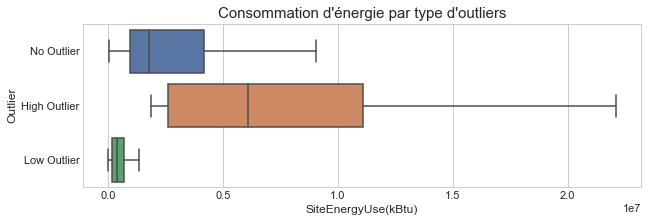

In [30]:
# on transforme la colonne Outlier en booléen ou on garde Low/High/No Outlier
data['Outlier_bool'] = np.where(data['Outlier'].isna(), False, True)
data['Outlier'] = data['Outlier'].fillna('No Outlier')

fig = plt.figure(figsize=(10,3))
sns.boxplot(x='SiteEnergyUse(kBtu)', 
            y="Outlier", 
            showfliers=False,
            orient='h', 
            data=data)
plt.title("Consommation d'énergie par type d'outliers", fontsize=15);

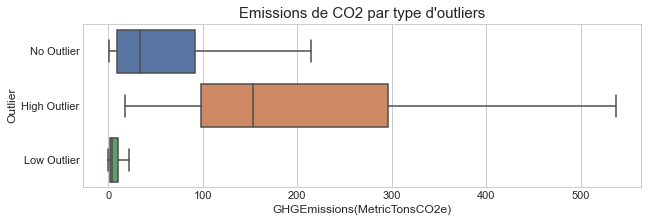

In [31]:
fig = plt.figure(figsize=(10,3))
sns.boxplot(x='GHGEmissions(MetricTonsCO2e)', 
            y="Outlier", 
            showfliers=False,
            orient='h', 
            data=data)
plt.title("Emissions de CO2 par type d'outliers", fontsize=15);

On rajoute des variables sur les différentes sources d'énergie utilisées : 
- variables booléennes d'utilisation ou non des différentes sources d'énergie
- ratio d'utilisation mais possible fuite de données
- source principale d'énergie primaire et secondaire


On peut potentiellement retirer 'Others' qui est déduit des autres.


In [32]:
# utilisation Y/N des différentes sources
data['Electricity'] = np.where(data['Electricity(kBtu)'] > 0, 1, 0)
data['Steam'] = np.where(data['SteamUse(kBtu)'] > 0, 1, 0)
data['NaturalGas'] = np.where(data['NaturalGas(kBtu)'] > 0, 1, 0)
data['OtherEnergy'] = np.where(data['OtherFuelUse(kBtu)'] > 0, 1, 0)

# ratio d'utilisation des différentes sources
data['Electricity_ratio'] = data['Electricity(kBtu)'] / data['SiteEnergyUse(kBtu)']
data['Steam_ratio'] = data['SteamUse(kBtu)'] / data['SiteEnergyUse(kBtu)']
data['NaturalGas_ratio'] = data['NaturalGas(kBtu)'] / data['SiteEnergyUse(kBtu)']
data['OtherEnergy_ratio'] = data['OtherFuelUse(kBtu)'] / data['SiteEnergyUse(kBtu)']

# source principale d'énergie primaire et secondaire
data['Primary_energy_source'] = data[['Electricity(kBtu)','SteamUse(kBtu)','NaturalGas(kBtu)',
                                      'OtherFuelUse(kBtu)']].idxmax(axis=1)
data['Secondary_energy_source'] = data[['Electricity(kBtu)','SteamUse(kBtu)','NaturalGas(kBtu)',
                                      'OtherFuelUse(kBtu)']].apply(lambda row: row.nlargest(2).index[-1], axis=1)

Superficies :

On remarque que la majorité des entrées n'ont pas une superficie totale égale à la somme des superficies des différents usages. Elle peut être supérieure si une partie du bâtiment a plusieurs usages, ou inférieure si tous les types d'usage ne sont pas précisés.


On a tout de même un nombre important d'erreurs de remplissage dans les superficies:
- la superficie totale peut être inférieure à la superficie d'un seul type d'usage
- des superficies de parking à 0 alors qu'un des trois types d'utilisation principaux est 'parking'.


On ne peut pas savoir si l'erreur est sur la superficie totale ou sur les superficies d'usage.


Pour le modèle on testera 3 solutions :
- on garde la superficie totale donnée uniquement
- on garde la superficie parking et la superficie buildings
- on garde les superficies par type primaire, secondaire et tertiaire.

In [33]:
# exemple où on peut constater des erreurs de remplissage des superficies d'usage ou totale
data[(data['LargestPropertyUseTypeGFA']) > (data['PropertyGFATotal'])][[
    'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA','PropertyGFATotal']]

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,PropertyGFATotal
11,336640.0,NaN,NaN,333176.0
22,58916.0,NaN,NaN,56228.0
30,164229.0,NaN,NaN,160645.0
31,55166.0,NaN,NaN,51582.0
37,182861.0,NaN,NaN,175565.0
...,...,...,...,...
3383,202171.0,108036.0,NaN,108036.0
3403,45728.0,0.0,NaN,45000.0
3407,42014.0,4941.0,NaN,41403.0
3409,71241.0,NaN,NaN,63825.0


In [34]:
# exemple où on peut constater un problème de remplissage des superficies de parking
data[(data['PropertyGFAParking'] == 0) & (data['LargestPropertyUseType'] == 'Parking')][[
    'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuilding(s)']]

,LargestPropertyUseType,LargestPropertyUseTypeGFA,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s)
302,Parking,155000.0,258497.0,0.0,258497.0
490,Parking,385196.0,516407.0,0.0,516407.0
2118,Parking,18000.0,36000.0,0.0,36000.0
2832,Parking,11021.0,21036.0,0.0,21036.0
2834,Parking,24288.0,32928.0,0.0,32928.0
3165,Parking,432903.0,333698.0,0.0,333698.0
3322,Parking,83600.0,33648.0,0.0,33648.0
3383,Parking,202171.0,108036.0,0.0,108036.0


Types des bâtiments :

- On ne gardera pas le 'BuildingType' qui est très large et nous servira seulement si on veut filtrer les bâtiments non résidentiels.
- On a le type d'utilisation principal 'PrimaryType' et les 3 principaux types d'utilisation avec leur superficie d'usage associée. 

In [35]:
# on rajoute la superficie d'usage des bâtiments par type

def get_type_dummies(data, use_type, use_gfa):
    '''
    Fonction qui créé une variable pour chaque type d'utilisation
    des bâtiments et assigne la superficie d'usage pour chacun de 
    ces types
    '''
    df = data[['OSEBuildingID', use_type, use_gfa]].copy(deep=True)
    df = pd.get_dummies(df, prefix='Type')
    for col in df.columns:
        if col.startswith('Type_'):
            df[col] = np.where(df[col] > 0, df[use_gfa], 0)
    return df
            
type1 = get_type_dummies(data, 'LargestPropertyUseType','LargestPropertyUseTypeGFA')
type2 = get_type_dummies(data, 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA')
type3 = get_type_dummies(data, 'ThirdLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA')

property_types = pd.concat([type1, type2, type3]).groupby('OSEBuildingID').sum().reset_index().drop(
                 columns=['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'])

In [36]:
data = data.merge(property_types, on=['OSEBuildingID'])

On vérifie si 'Neighborhood' et 'CouncilDistrictCode' représentent exactement les mêmes zones. On constate qu'un quartier peut s'étaler sur plusieurs districts et inversement. Les deux variables ne se recoupent pas toujours, on peut potentiellement utiliser les deux en même temps.

In [37]:
pd.crosstab(data['Neighborhood'], data['CouncilDistrictCode']) 

CouncilDistrictCode,1.0,2.0,3.0,4.0,5.0,6.0,7.0
Neighborhood,,,,,,,
BALLARD,0,0,0,0,0,136,0
CENTRAL,0,0,134,0,0,0,0
DELRIDGE,86,0,0,0,0,0,0
DOWNTOWN,0,80,11,0,0,0,491
EAST,0,1,423,0,0,0,33
GREATER DUWAMISH,31,339,4,0,0,0,0
LAKE UNION,0,0,15,101,0,39,101
MAGNOLIA / QUEEN ANNE,0,0,0,0,0,0,426
NORTH,0,0,0,3,187,0,0


## Filtre sur les bâtiments résidentiels

In [38]:
# On ne garde que les bâtiments non résidentiels

building_types = ['NonResidential', 'Nonresidential COS', 'Nonresidential WA', 'SPS-District K-12', 'Campus']

print("Nb total d'entrées :\n", data.shape[0],)

data = data[data['BuildingType'].isin(building_types)]

print("Nb d'entrées non-résidentielles :\n", data.shape[0])

Nb total d'entrées :
 3409
Nb d'entrées non-résidentielles :
 1683


## Analyse des variables à prédire

On peut voir une forte corrélation entre les émissions de CO2 et la consommation d'énergie. On pourra sans doute utiliser les mêmes variables pour les deux modèles de prédiction.

### Consommation d'énergie

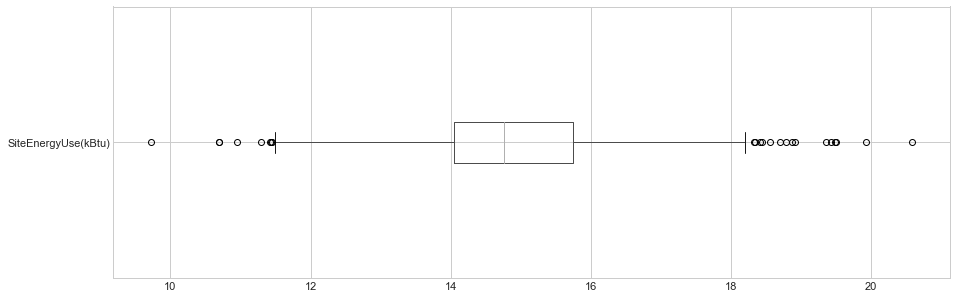

In [39]:
fig = plt.figure(figsize=(15,5))
np.log1p(data[['SiteEnergyUse(kBtu)']]).boxplot(column=['SiteEnergyUse(kBtu)'], vert=False)#, showfliers=False)
plt.show()

In [40]:
def trace_histplot(data, title, y_max=0, x_max=0):
    fig = plt.figure(figsize=(15,10))
    sns.histplot(data, kde=True)
    if y_max > 0:
        plt.ylim(0, y_max)
    if x_max > 0:
        plt.xlim(0, x_max)
    line = plt.axvline(data.mean(), color='r', label='moyenne')
    line2 = plt.axvline(data.median(), color='g', label='médiane')
    plt.title(title, fontsize=15)
    plt.legend(loc='upper right'); 

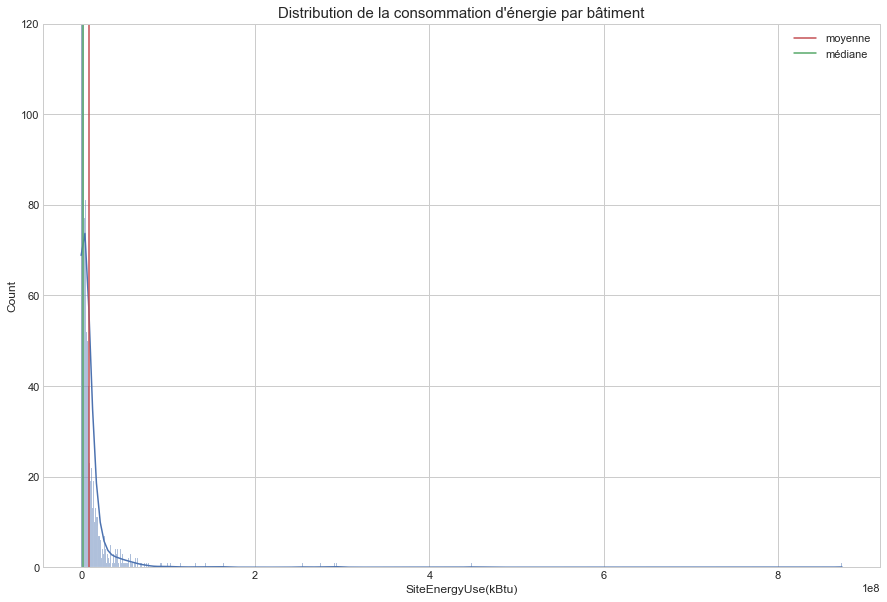

In [41]:
trace_histplot(data['SiteEnergyUse(kBtu)'], "Distribution de la consommation d'énergie par bâtiment", y_max=120)

### Emissions de CO2

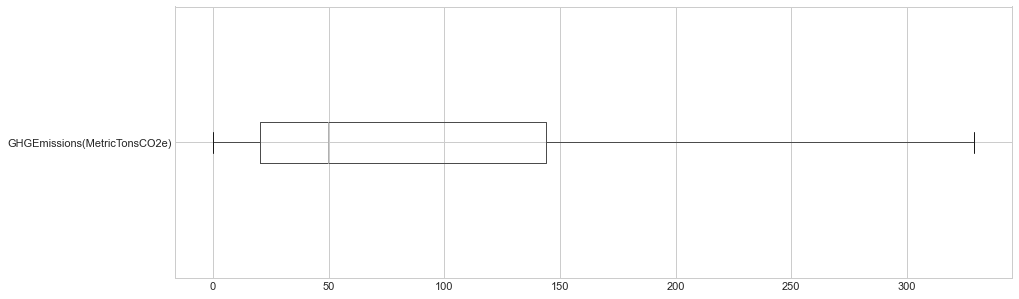

In [42]:
fig = plt.figure(figsize=(15,5))
data.boxplot(column=['GHGEmissions(MetricTonsCO2e)'], vert=False, showfliers=False)
plt.show()

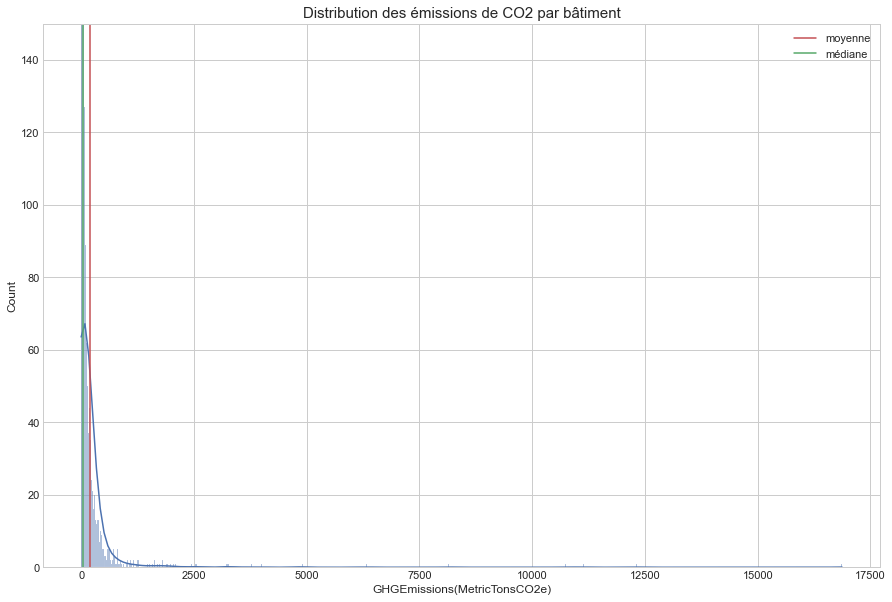

In [43]:
trace_histplot(data['GHGEmissions(MetricTonsCO2e)'], "Distribution des émissions de CO2 par bâtiment", y_max=150)

### Outliers

Les deux plus grosses consommations correspondent à une Energy/Power Station et un campus universitaire de 111 bâtiments.

Les autres consommations importantes sont principalement des hôpitaux et campus.

Les bâtiments que l'on repère en tant qu'outliers avec le z-score ne sont pas considérés comme tels selon la colonne 'Outlier'. On testera les modèles avec et sans les outliers, mais on les gardera si possible car ce ne sont pas des aberrations, ce sont des bâtiments qui ont des caractéristiques cohérentes avec le fait d'être des outliers (taille, nombre ou type des bâtiments). 

In [44]:
mean_energy_use = data['SiteEnergyUse(kBtu)'].mean()
std_energy_use = data['SiteEnergyUse(kBtu)'].std()
data['z_score_energy'] = data.apply(lambda x : (x['SiteEnergyUse(kBtu)'] - mean_energy_use) / std_energy_use, axis=1)
data[data['z_score_energy'] > 3][['BuildingType', 'PropertyName', 'PrimaryPropertyType', 'SiteEnergyUse(kBtu)', 'z_score_energy', 'Outlier']]

,BuildingType,PropertyName,PrimaryPropertyType,SiteEnergyUse(kBtu),z_score_energy,Outlier
121,NonResidential,Seattle Children's Hospital Main Campus,Hospital,253832464.0,8.075612,No Outlier
165,NonResidential,Swedish Cherry Hill,Hospital,143423024.0,4.440238,No Outlier
168,NonResidential,Harborview Medical Center,Hospital,293090784.0,9.368243,No Outlier
339,Campus,Weintraub/Hutchinson/Thomas,Other,131373880.0,4.043505,No Outlier
557,NonResidential,WestinBuilding,Other,274682208.0,8.762117,No Outlier
617,NonResidential,Swedish First Hill,Hospital,291614432.0,9.319632,No Outlier
1501,Campus,Entire Campus,College/University,114648520.0,3.492801,No Outlier
1702,NonResidential,Central Campus,Medical Office,102673696.0,3.098514,No Outlier
3251,Campus,AMGEN INC. MASTER CAMPUS,Other,157606480.0,4.907247,No Outlier
3284,NonResidential,Virginia Mason Medical Center - 2149,Hospital,163945984.0,5.115983,No Outlier


In [45]:
mean_co2 = data['GHGEmissions(MetricTonsCO2e)'].mean()
std_co2 = data['GHGEmissions(MetricTonsCO2e)'].std()
data['z_score_co2'] = data.apply(lambda x : (x['GHGEmissions(MetricTonsCO2e)'] - mean_co2) / std_co2, axis=1)
data[(data['z_score_co2'] > 3) | (data['z_score_energy'] > 3)][['BuildingType', 'PropertyName', 'PrimaryPropertyType', 'SiteEnergyUse(kBtu)', 'z_score_energy','z_score_co2', 'Outlier']]

,BuildingType,PropertyName,PrimaryPropertyType,SiteEnergyUse(kBtu),z_score_energy,z_score_co2,Outlier
121,NonResidential,Seattle Children's Hospital Main Campus,Hospital,253832464.0,8.075612,10.484352,No Outlier
165,NonResidential,Swedish Cherry Hill,Hospital,143423024.0,4.440238,6.215863,No Outlier
168,NonResidential,Harborview Medical Center,Hospital,293090784.0,9.368243,13.896110,No Outlier
260,NonResidential,Fairmont Olympic Seattle,Hotel,56485204.0,1.577698,3.142072,No Outlier
339,Campus,Weintraub/Hutchinson/Thomas,Other,131373880.0,4.043505,5.015538,No Outlier
557,NonResidential,WestinBuilding,Other,274682208.0,8.762117,2.282982,No Outlier
617,NonResidential,Swedish First Hill,Hospital,291614432.0,9.319632,15.968413,No Outlier
1501,Campus,Entire Campus,College/University,114648520.0,3.492801,4.024619,No Outlier
1684,NonResidential,Main Hospital - All Wings,Hospital,98960776.0,2.976261,4.070253,No Outlier
1702,NonResidential,Central Campus,Medical Office,102673696.0,3.098514,4.017714,No Outlier


### Corrélation entre les variables et Energy Star Score


On voudrait connaître l'utilité de l'Energy Star Score pour aider à prédire les émissions de CO2.

On sait que l'ESS est calculé entre autre avec le 'SourceEUIWN(kBtu/sf)' et en comparant avec des bâtiments du même 'PrimaryPropertyType'.

On ne voit pas de corrélation linéaire directe entre l'ESS et les émissions de CO2.

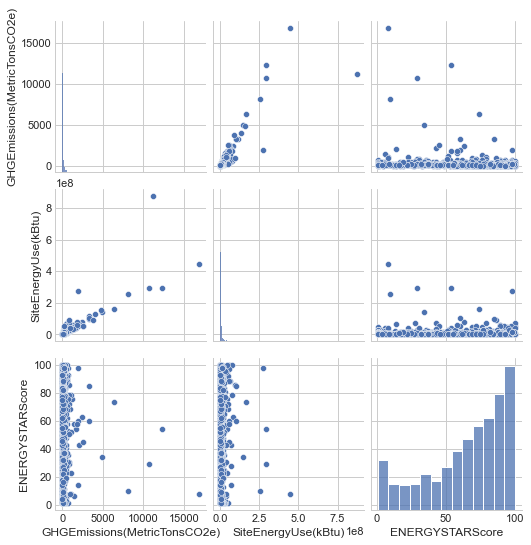

In [46]:
sns.pairplot(data[['GHGEmissions(MetricTonsCO2e)', 'SiteEnergyUse(kBtu)', 'ENERGYSTARScore']]);

<AxesSubplot:>

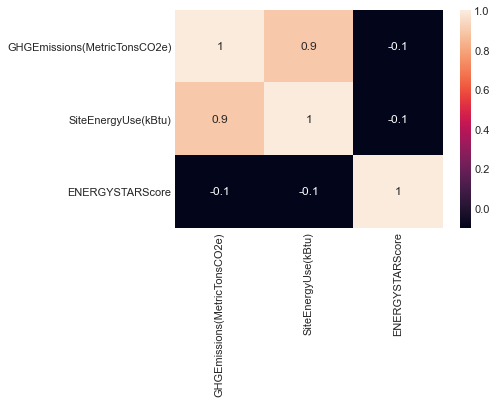

In [47]:
matrice_corr = data[['GHGEmissions(MetricTonsCO2e)', 'SiteEnergyUse(kBtu)', 'ENERGYSTARScore']].corr().round(1)
sns.heatmap(data=matrice_corr, annot=True)

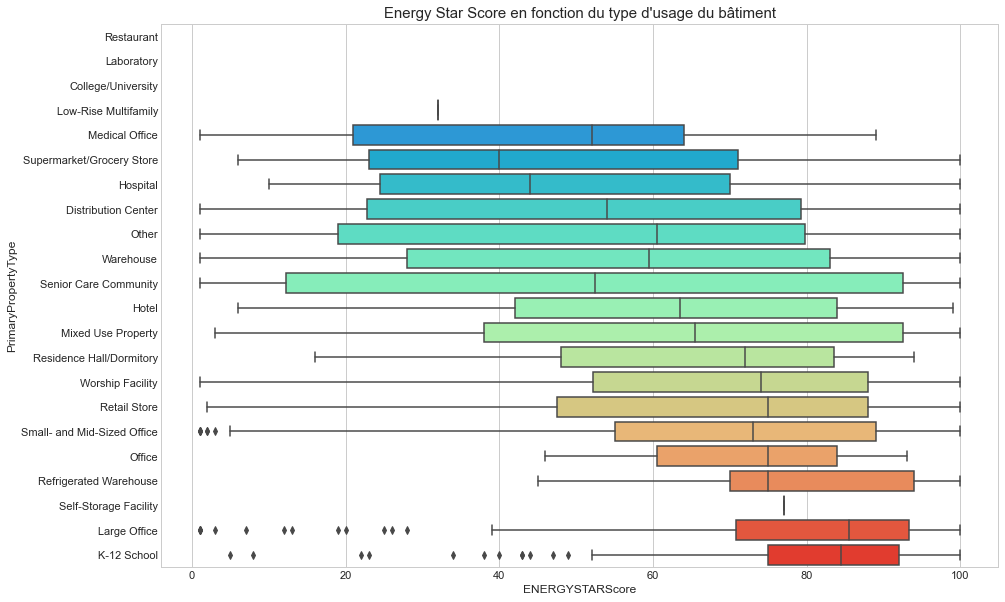

In [48]:
type_order = data.groupby(by=["PrimaryPropertyType"])["ENERGYSTARScore"].mean().sort_values(ascending=False).iloc[::-1].index
fig = plt.figure(figsize=(15,10))
sns.boxplot(x='ENERGYSTARScore',y='PrimaryPropertyType',data=data, order=type_order, palette='rainbow')
plt.title("Energy Star Score en fonction du type d'usage du bâtiment", fontsize=15);

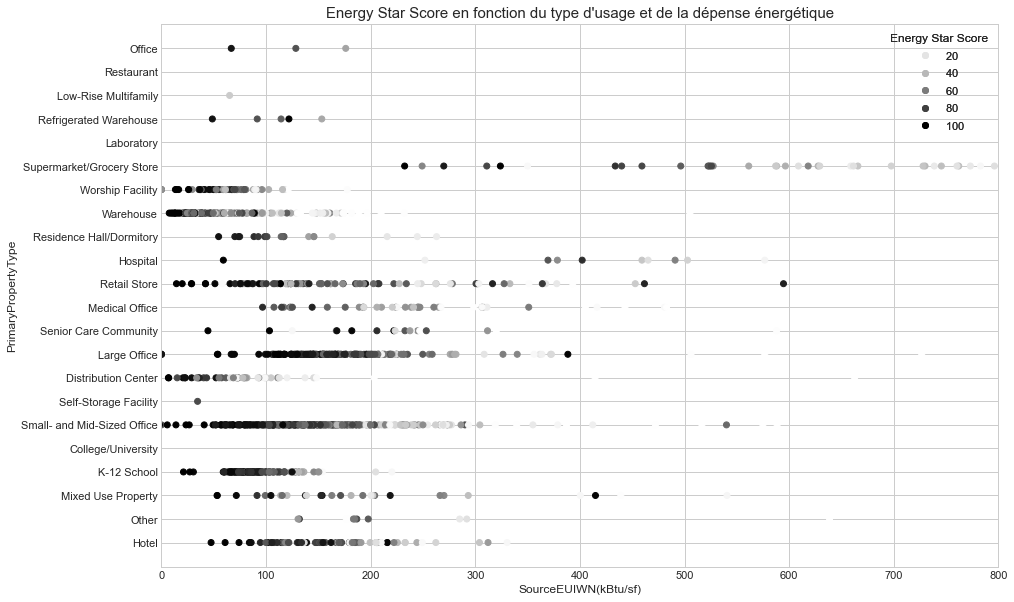

In [49]:
fig, ax = plt.subplots(figsize=(15,10))

scatter = ax.scatter(x=data['SourceEUIWN(kBtu/sf)'],y=data['PrimaryPropertyType'], c=data['ENERGYSTARScore'])

legend = ax.legend(*scatter.legend_elements(num=5),
                    loc="upper right", title="Energy Star Score")
ax.add_artist(legend)
plt.xlim(0, 800)
plt.title("Energy Star Score en fonction du type d'usage et de la dépense énergétique" , fontsize=15)
plt.xlabel('SourceEUIWN(kBtu/sf)')
plt.ylabel('PrimaryPropertyType');

In [50]:
data.drop(columns=['Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
                   'LargestPropertyUseType','LargestPropertyUseTypeGFA','SecondLargestPropertyUseType',
                   'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA',
                   'Comment', 'OSEBuildingID', 'YearBuilt', 'ListOfAllPropertyUseTypes', 'PropertyName', 
                   'z_score_energy', 'z_score_co2'], inplace=True)

In [51]:
data.to_csv('data.csv')